#### Introduction
---

- This is further continuoation of exploring the trade deficit dataset I personally gathered. In the paper, I've explored the emperical evidence for the marshall-Lerner between the US and Canada, with a mroe traditional statistical/econometrics framework, VAR time serie smodels and OLS. ADditionally, the variables used were based on economic theory, demand functions and the real interest rate as the price for exports and imports.
&nbsp;
- Here, I've added several other variables, which although might be important, their effects don't fit the traditional variables specified for such research. The resulting effect of such variables might be apparent in causalty analysis, which were explored in the paper, I'll ignore the side effects like the violations of classical assumptions of models here, i.e. heteroscedasticity, autocorrelation, etc.
---


#### importing the libraries and loading the dataset
---

In [219]:
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import statsmodels.api as sm

from IPython.display import display, Math, Latex

In [220]:
warnings.filterwarnings("ignore")

In [221]:
# loading the dataset

file_path = r"../../data_original.xlsx"
data = pd.read_excel(file_path)
data.head()

,year,trade_deficit,covid_dummy,"GDP of canada, in billions USD","GDP of the US, in billions",nominal exchange rate USD/CAD,deflator_canada,deflator_usa,cpi_canada,cpi_usa,...,Global econ policy uncertainty index,US econ policy uncertainty index,M2 US,M2 Canada,interest rate Canada,PPI Canada,PPI US,interest rate US,FDI US,migration fear US
0,2003,-712.331648,0,314686.928702,15162760.0,0.761731,79.575453,77.639,81.538056,185.500,...,70.478538,90.34359,6067.3,567295,4.729048,80.021339,139.5,0.98,1658275,88.290131
1,2004,-851.752241,0,352045.696940,15670880.0,0.820412,82.280018,79.939,83.276271,191.700,...,64.967186,66.53288,6418.3,603920,4.320476,83.115497,150.2,2.16,1830644,95.930206
2,2005,-953.674088,0,381695.652174,16136734.0,0.860956,85.601587,82.571,85.014485,198.100,...,60.622293,70.02676,6681.9,642923,4.041000,85.356095,163.0,4.16,2007151,90.102013
3,2006,-888.751877,0,390398.022893,16561866.0,0.867152,86.896102,84.770,86.436661,203.100,...,56.872640,51.03904,7071.6,678248,3.966316,88.236863,165.6,5.24,2255955,116.371735
4,2007,-781.766393,0,458809.799421,16915191.0,0.997904,90.129249,86.993,88.490914,211.445,...,95.535370,116.99090,7471.6,739943,4.015789,87.810083,178.6,4.24,2463600,112.055168


### Relevance of Variables in Predicting Budget Deficit

Each variable listed below contributes to a comprehensive view of the economy's health, stability, and growth potential:

1. **covid_dummy**:
   - Indicates the presence of the COVID-19 pandemic, significantly impacting economic activities and government budgets.

2. **gdp_canada ('GDP of Canada, in billions USD')**:
   - Represents the total economic output of Canada. Higher GDP generally suggests better economic health and potential for higher tax revenues.

3. **gdp_us ('GDP of the US, in billions')**:
   - The economic performance of the US can significantly influence Canada due to close economic ties.

4. **nominal_exchange_rate ('nominal exchange rate USD/CAD')**:
   - Influences the value of international trade. A stronger CAD against the USD can affect imports and exports.

5. **deflator_canada**:
   - A measure of inflation used to convert nominal GDP to real GDP, indicating the true economic growth.

6. **deflator_usa**:
   - Similar to Canada’s deflator, reflecting inflation and economic growth in the US, impacting Canada through trade and economic policies.

7. **cpi_canada**:
   - Consumer Price Index indicating the level of retail price inflation which affects purchasing power and economic stability.

8. **cpi_usa**:
   - Measures inflation in the US, affecting economic policy and trade between the US and Canada.

9. **real_exchange_rate ('real exchange charge rate using CPI')**:
   - A more accurate measure of the exchange rate adjusted for inflation differences, impacting trade and investment flows.

10. **unemployment_rate_us ('unemployment rate US')**:
    - Affects consumer confidence and spending, influencing economic interactions with Canada.

11. **global_econ_policy_uncertainty ('Global econ policy uncertainty index')**:
    - Measures global economic uncertainty, impacting investment, trade, and economic policy decisions worldwide.

12. **us_econ_policy_uncertainty ('US econ policy uncertainty index')**:
    - Reflects economic policy uncertainty in the US, directly influencing Canada’s economic and political environment.

13. **m2_us ('M2 US')**:
    - A measure of the money supply that indicates monetary policy, inflation, and economic conditions.

14. **m2_canada ('M2 Canada')**:
    - Similar to M2 US, it impacts domestic monetary policy and economic stability.

15. **interest_rate_canada ('interest rate Canada')**:
    - Affects borrowing costs, spending, investment, and overall economic activity.

16. **ppi_canada ('PPI Canada')**:
    - Producer Price Index reflecting the average level of wholesale price inflation which can indicate economic trends.

17. **ppi_us ('PPI US')**:
    - Similar to PPI Canada, it impacts the costs of goods imported from the US, affecting inflation and economic policies.

18. **interest_rate_us ('interest rate US')**:
    - US interest rates influence global financial markets and investment flows, indirectly affecting Canada.

19. **fdi_us ('FDI US')**:
    - Foreign Direct Investment from the US can drive economic growth and development in Canada.

20. **migration_fear_us ('migration fear US')**:
    - Reflects concerns or policies affecting migration from the US, which can influence labor markets and economic stability in Canada.

In [222]:
# dropping the Y column

subset_df = data.set_index('year')
subset_df.drop(['trade_deficit', 'covid_dummy'], axis=1, inplace=True)

#### Clustering
---

In [223]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(subset_df)

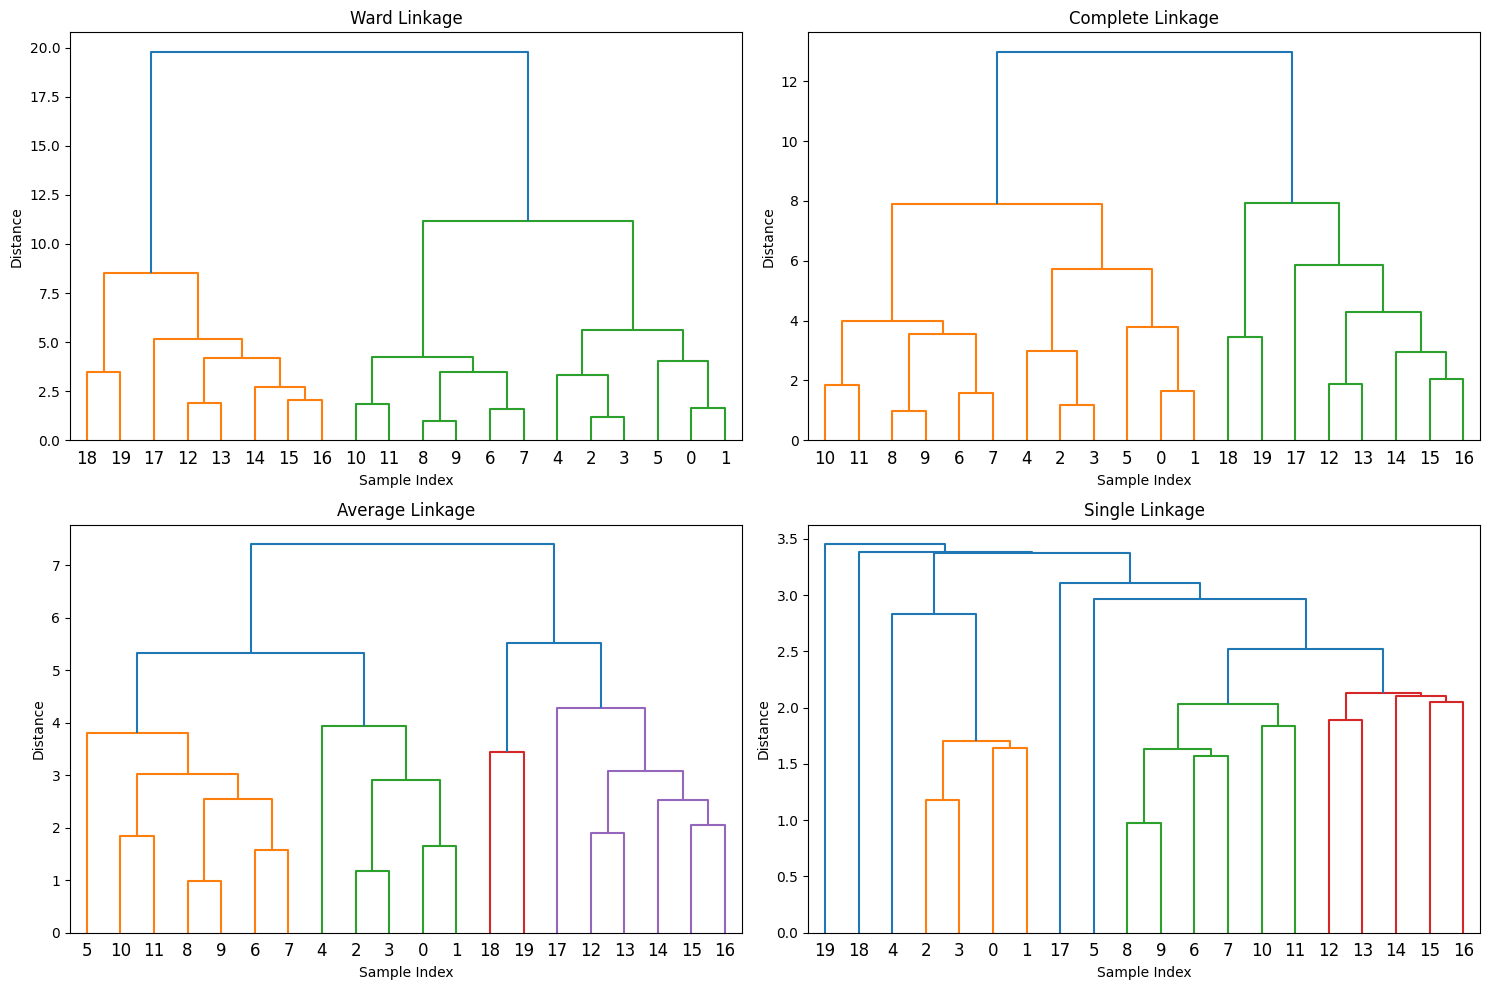

In [224]:
Z_ward = linkage(data_scaled, method='ward')
Z_complete = linkage(data_scaled, method='complete')
Z_average = linkage(data_scaled, method='average')
Z_single = linkage(data_scaled, method='single')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Ward
axes[0, 0].set_title('Ward Linkage')
dendrogram(Z_ward, ax=axes[0, 0])
axes[0, 0].set_xlabel('Sample Index')
axes[0, 0].set_ylabel('Distance')

# Complete
axes[0, 1].set_title('Complete Linkage')
dendrogram(Z_complete, ax=axes[0, 1])
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Distance')

# Average
axes[1, 0].set_title('Average Linkage')
dendrogram(Z_average, ax=axes[1, 0])
axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('Distance')

# Single
axes[1, 1].set_title('Single Linkage')
dendrogram(Z_single, ax=axes[1, 1])
axes[1, 1].set_xlabel('Sample Index')
axes[1, 1].set_ylabel('Distance')

plt.tight_layout()
plt.show()

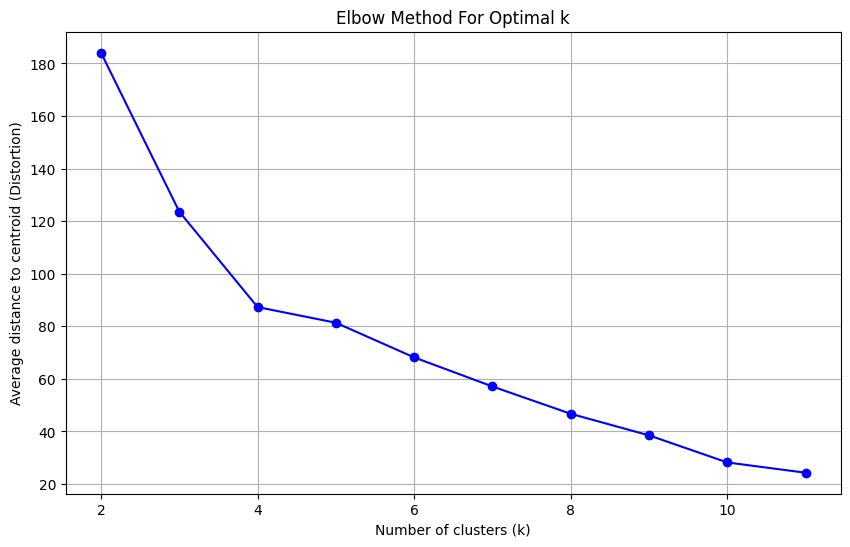

In [225]:
distortions = []
K = range(2, 12)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    distortions.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average distance to centroid (Distortion)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

**Dendrogram** can help visualize the hierarchical relationships between data points and determine the optimal number of clusters.

#### Key Points
- I removed the COVID dummy variable, which I had added manually, since its effects were explored while visualizing the dataset. Interestingly, the dendrograms show that the algorithms are clustering points 18 and 19 separately in a single cluster. Hence, keeping the dummy variable is not beneficial.
&nbsp;
- Both dendrograms and the average distance graphs provide evidence that 4 is the optimal number of clusters. I can cut through the dendrogram using the `fcluster` method and the maximum distance or choose the maximum number of clusters; both approaches should yield the same results.


In [226]:
"""
clusters_ward = fcluster(Z_ward, 7.5, criterion='distance')
clusters_complete = fcluster(Z_complete, 6.5, criterion='distance')
clusters_average = fcluster(Z_average, 4.5, criterion='distance')
clusters_single = fcluster(Z_single, 2.5, criterion='distance')
"""

m=4
model_ward = AgglomerativeClustering(n_clusters=m, metric='euclidean', linkage='ward')
clusters_ward = model_ward.fit_predict(data_scaled)

model_complete = AgglomerativeClustering(n_clusters=m, metric='euclidean', linkage='complete')
clusters_complete = model_complete.fit_predict(data_scaled)

model_average = AgglomerativeClustering(n_clusters=m, metric='euclidean', linkage='average')
clusters_average = model_average.fit_predict(data_scaled)

model_single = AgglomerativeClustering(n_clusters=m, metric='euclidean', linkage='single')
clusters_single = model_single.fit_predict(data_scaled)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters_kmeans = kmeans.fit_predict(data_scaled)


print("Ward linkage:", clusters_ward)
print("Complete linkage:", clusters_complete)
print("Average linkage:", clusters_average)
print("Single linkage:", clusters_single)

Ward linkage: [0 0 0 0 0 0 2 2 2 2 2 2 1 1 1 1 1 1 3 3]
Complete linkage: [1 1 1 1 1 1 3 3 3 3 3 3 0 0 0 0 0 0 2 2]
Average linkage: [1 1 1 1 1 3 3 3 3 3 3 3 0 0 0 0 0 0 2 2]
Single linkage: [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 3]


#### Trend Removal and Clustering Analysis

One interesting fact from the results is, evernthough I've approched the clustering without providing the trade deficit amount, the clustering algorithms are clearly picking up the structural breaks of the trade deficit data points. This emphasizes the interconnectivity of economic variables.
**Capturing Deviations**: One interesting way to cluster them is using deviations from its long-term trend. This approach can reveal shifts in government and central bank policies, and providing insights into the current stage of the economic cycle.

> The stages of economic cycles, often referred to as the business cycle or economic cycle, are typically divided into four phases: expansion, peak, contraction, and trough. Each stage represents a different condition in the overall economy.
> 1. **Expansion**:
>     - Increasing economic activity
>     - Rising GDP, employment, income, and production
>     - High consumer confidence and spending
>     - Potential rise in inflation
>
> 2. **Peak**:
>     - Transition from expansion to contraction
>     - Highest levels of economic indicators
>     - Slowdown in growth rates
>     - High inflation concerns
>
> 3. **Contraction**:
>     - Declining economic activity
>     - Decreasing GDP, production, and employment
>     - Lower consumer confidence and spending
>     - Potential deflation in severe cases
>
> 4. **Trough**:
>     - Transition from contraction to expansion
>     - Lowest levels of economic indicators
>     - End of recession and beginning of recovery
>     - Gradual improvement in consumer confidence


**Note** One drawback of this approach will be that the trend line might not be linear at all, resulting in a biased model. Additionally, linear trend assumes that the growth rate is constant. however, carefully modeling a linear trend for all the variables is time-consuming, and I'll continue with the linearity assumption to further simplify.

**steps are**
>I'll regress each point on its corresponding year value. The error of the regression will be the variations in data which couldn't be explained with the time variable.

>The linear regression model can be defined as follows:
>$$ y_i = \beta_0 + \beta_1 \cdot t_i + \epsilon_i $$

>Where:
>- $y_i$ is the value of the dependent variable at time $t_i$
>- $\beta_0$ is the intercept of the trend line
>- $\beta_1$ is the slope of the trend line
>- $t_i$ is the year (independent variable)
>- $\epsilon_i$ is the error term (residual) for the $i$-th observation

>The deviation amount (error term) is then:

>$$ \epsilon_i = y_i - (\beta_0 + \beta_1 \cdot t_i) $$


In [227]:
def detrend_variable(variable):
    model = LinearRegression()
    X = pd.to_numeric(variable.index).values.reshape(-1, 1)
    model.fit(X, variable)
    detrended_variable = variable - model.predict(X)
    return detrended_variable, model

detrended_and_models = subset_df.apply(detrend_variable)
detrended_data = detrended_and_models.apply(lambda x: x[0])

In [228]:
# creating the models dictionary for saving the models and clustroids/centroids
models = {}

for column_name, (detrended, model) in detrended_and_models.items():
    models[column_name] = model

In [229]:
scaler = StandardScaler()
data_detrended_scaled = scaler.fit_transform(detrended_data)

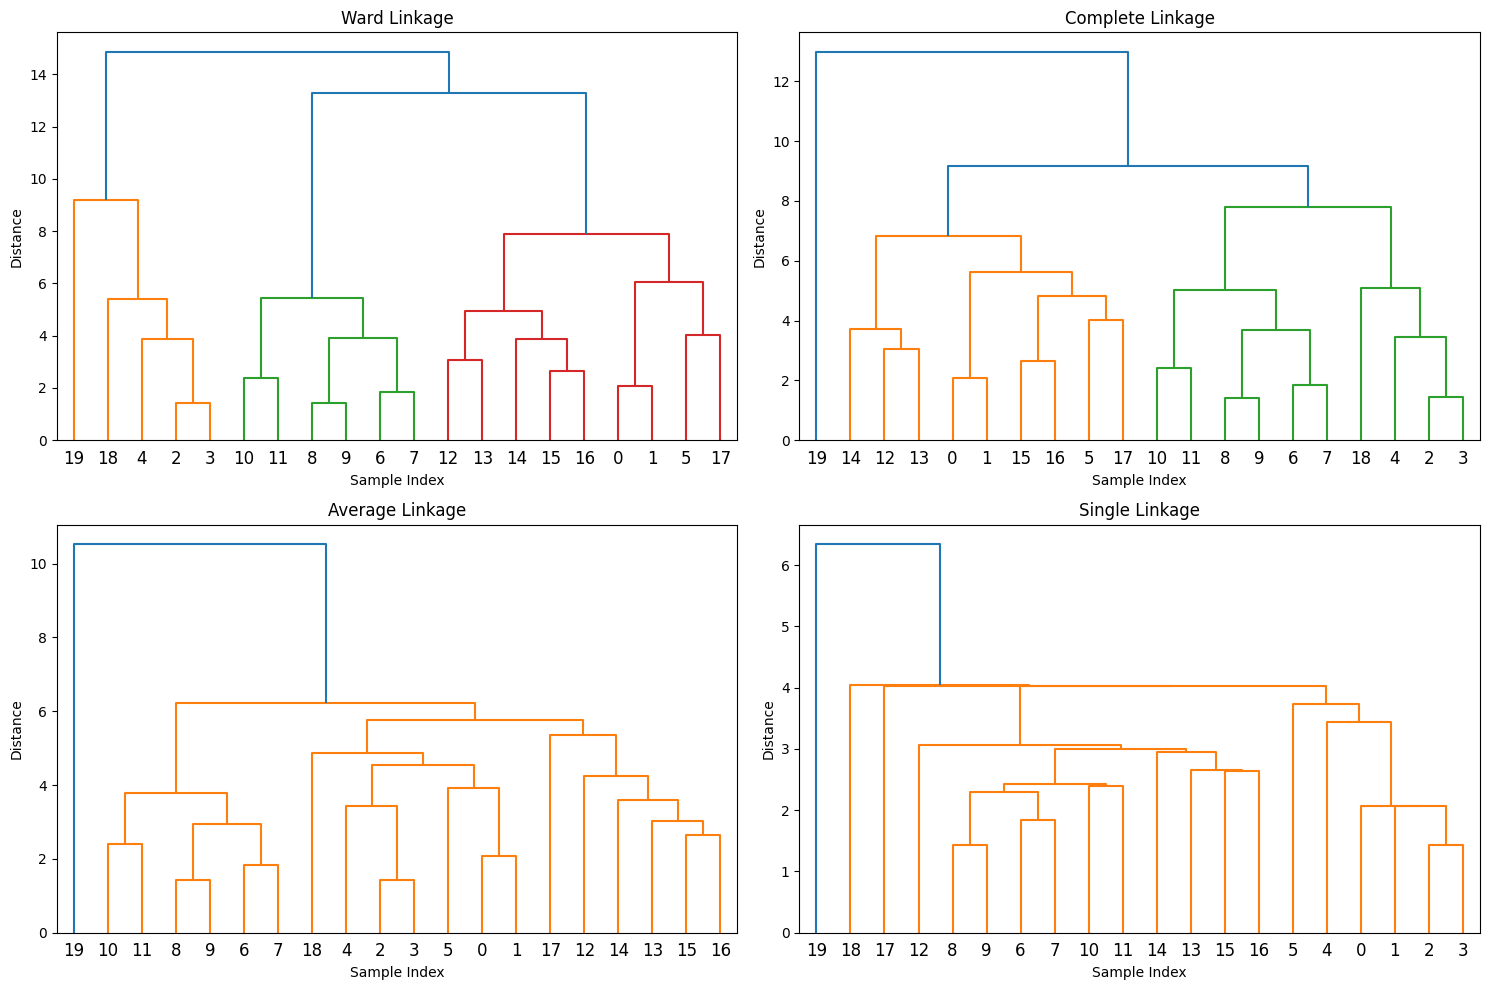

In [230]:
# Compute the linkage matrix for each method
Z_ward = linkage(data_detrended_scaled, method='ward')
Z_complete = linkage(data_detrended_scaled, method='complete')
Z_average = linkage(data_detrended_scaled, method='average')
Z_single = linkage(data_detrended_scaled, method='single')

# Plotting the dendrograms in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Ward
axes[0, 0].set_title('Ward Linkage')
dendrogram(Z_ward, ax=axes[0, 0])
axes[0, 0].set_xlabel('Sample Index')
axes[0, 0].set_ylabel('Distance')

# Complete
axes[0, 1].set_title('Complete Linkage')
dendrogram(Z_complete, ax=axes[0, 1])
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Distance')

# Average
axes[1, 0].set_title('Average Linkage')
dendrogram(Z_average, ax=axes[1, 0])
axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('Distance')

# Single
axes[1, 1].set_title('Single Linkage')
dendrogram(Z_single, ax=axes[1, 1])
axes[1, 1].set_xlabel('Sample Index')
axes[1, 1].set_ylabel('Distance')

plt.tight_layout()
plt.show()

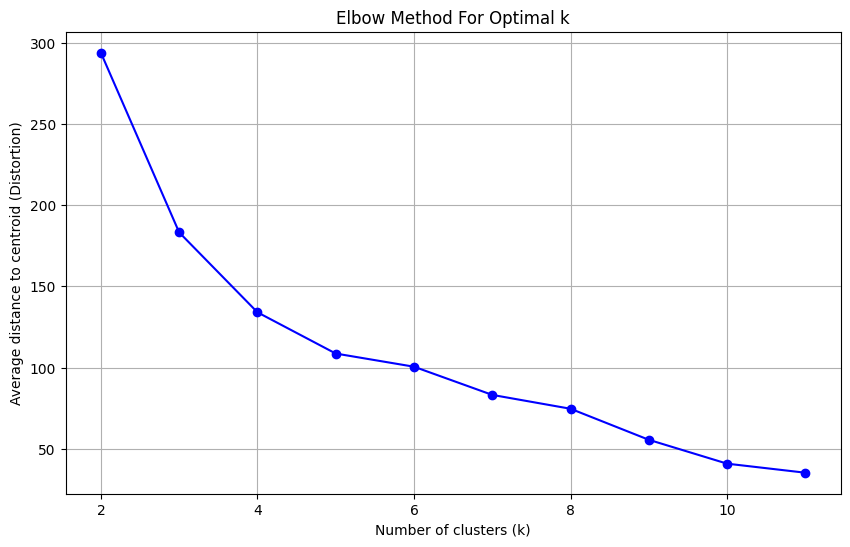

In [231]:
distortions = []
K = range(2, 12)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_detrended_scaled)
    distortions.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average distance to centroid (Distortion)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

In [232]:
# Hierarchical clustering with different linkage criteria detre
m=4
model_ward_detrend = AgglomerativeClustering(n_clusters=m, metric='euclidean', linkage='ward')
clusters_ward_detrend = model_ward_detrend.fit_predict(data_detrended_scaled)

model_complete_detrend = AgglomerativeClustering(n_clusters=m, metric='euclidean', linkage='complete')
clusters_complete_detrend = model_complete_detrend.fit_predict(data_detrended_scaled)

model_average_detrend = AgglomerativeClustering(n_clusters=m, metric='euclidean', linkage='average')
clusters_average_detrend = model_average_detrend.fit_predict(data_detrended_scaled)

model_single_detrend = AgglomerativeClustering(n_clusters=m, metric='euclidean', linkage='single')
clusters_single_detrend = model_single_detrend.fit_predict(data_detrended_scaled)

kmeans_detrend = KMeans(n_clusters=4, random_state=42)
clusters_kmeans_detrend = kmeans_detrend.fit_predict(data_detrended_scaled)

print("Ward linkage:", clusters_ward_detrend)
print("Complete linkage:", clusters_complete_detrend)
print("Average linkage:", clusters_average_detrend)
print("Single linkage:", clusters_single_detrend)
print("kmeans:", clusters_kmeans_detrend)

Ward linkage: [0 0 1 1 1 0 2 2 2 2 2 2 0 0 0 0 0 0 1 3]
Complete linkage: [0 0 2 2 2 0 1 1 1 1 1 1 0 0 0 0 0 0 2 3]
Average linkage: [1 1 1 1 1 1 2 2 2 2 2 2 0 0 0 0 0 0 1 3]
Single linkage: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 2 1]
kmeans: [2 2 2 2 2 2 0 0 0 0 0 0 1 1 1 1 1 1 2 3]


**Note** The results are printed out above. As expected, the clusters don't reflect and follow the time trend anymore. In the next section I'll take a look at the resuling clusters in more detail.


#### Visualization, analysis and exploration of the predictive performance of the clustering algorithms
---

In [233]:
clustering_methods = [
    'clusters_ward', 'clusters_complete', 'clusters_average', 'clusters_single',
    'clusters_kmeans', 'clusters_ward_detrend', 'clusters_complete_detrend',
    'clusters_average_detrend', 'clusters_single_detrend', 'clusters_kmeans_detrend'
]

cluster_data = pd.DataFrame({
    'clusters_ward': clusters_ward,
    'clusters_complete': clusters_complete,
    'clusters_average': clusters_average,
    'clusters_single': clusters_single,
    'clusters_kmeans': clusters_kmeans,
    'clusters_ward_detrend': clusters_ward_detrend,
    'clusters_complete_detrend': clusters_complete_detrend,
    'clusters_average_detrend': clusters_average_detrend,
    'clusters_single_detrend': clusters_single_detrend,
    'clusters_kmeans_detrend': clusters_kmeans_detrend,
})

In [234]:
print(f"Adjusted Rand Index for Ward: {adjusted_rand_score(clusters_ward, clusters_ward_detrend)}")
print(f"Adjusted Rand Index for Complete: {adjusted_rand_score(clusters_complete, clusters_complete_detrend)}")
print(f"Adjusted Rand Index for Average: {adjusted_rand_score(clusters_average, clusters_average_detrend)}")
print(f"Adjusted Rand Index for Single: {adjusted_rand_score(clusters_single, clusters_single_detrend)}")
print(f"Adjusted Rand Index for kmeans: {adjusted_rand_score(clusters_kmeans, clusters_kmeans_detrend)}")

Adjusted Rand Index for Ward: 0.5888594164456233
Adjusted Rand Index for Complete: 0.5888594164456233
Adjusted Rand Index for Average: 0.7526399537104007
Adjusted Rand Index for Single: 0.2654639175257732
Adjusted Rand Index for kmeans: 0.7526399537104007


**Note** Rand score ranges from -1 (two completely different clusters) to 1 (exact same cluster).
It seems as if the clusters are somewhat similar except for the Single linkage, which was heavily influenced by the detrend prcess

In [235]:
features = subset_df.columns

# Function to calculate the coefficient of variation for each feature within each clustering method
def calculate_variation(data_df, cluster_df, features, cluster_col):
    grouped = pd.concat([data_df, cluster_df], axis=1).groupby(cluster_col)[features].mean()
    variation = grouped.std() / grouped.mean() * 100  # Coefficient of variation (in percentage)
    return variation

# Calculate the coefficient of variation without the covid_dummy feature
cluster_variation_no_covid = {}
for cluster_col in clustering_methods:
    if 'detrend' in cluster_col:
        cluster_variation_no_covid[cluster_col] = calculate_variation(detrended_data, cluster_data, features, cluster_col)
    else:
        cluster_variation_no_covid[cluster_col] = calculate_variation(data, cluster_data, features, cluster_col)

# Combine the variations into a single DataFrame for comparison
variation_df_no_covid = pd.concat(cluster_variation_no_covid, axis=1)

top_features = {}
# Function to get the top 3 features with the highest variation for each clustering algorithm
def get_top_features_corrected(variation_df, top_n=3):
    for cluster_col in variation_df.columns.get_level_values(0).unique():
        top_features[cluster_col] = variation_df[cluster_col].nlargest(top_n).index.tolist()
    return top_features

# Get the top 3 features with the highest variation for each clustering algorithm
top_features_no_covid = get_top_features_corrected(variation_df_no_covid)

# Create a table to display the top features for each algorithm
top_features_df_no_covid = pd.DataFrame.from_dict(top_features).T
top_features_df_no_covid

,0,1,2
clusters_ward,interest rate US,M2 Canada,M2 US
clusters_complete,interest rate US,M2 Canada,M2 US
clusters_average,interest rate US,Global econ policy uncertainty index,M2 Canada
clusters_single,interest rate US,M2 Canada,Global econ policy uncertainty index
clusters_kmeans,interest rate US,M2 Canada,Global econ policy uncertainty index
clusters_ward_detrend,"GDP of canada, in billions USD","GDP of the US, in billions",nominal exchange rate USD/CAD
clusters_complete_detrend,"GDP of canada, in billions USD","GDP of the US, in billions",nominal exchange rate USD/CAD
clusters_average_detrend,"GDP of canada, in billions USD","GDP of the US, in billions",nominal exchange rate USD/CAD
clusters_single_detrend,"GDP of canada, in billions USD","GDP of the US, in billions",nominal exchange rate USD/CAD
clusters_kmeans_detrend,"GDP of canada, in billions USD","GDP of the US, in billions",nominal exchange rate USD/CAD


It seems as if the clusters before detrending have used levels in monetary policies as main features to do the task of clustering, but focused on the deviations from GDPs long-term equilibrium as its main focus after detrending.
&nbsp;

**Regarding the relationship between monetary policy and import and export levels,**
>Monetary policy in the U.S. and Canada, particularly interest rates and the money supply (M2), significantly impacts the trade deficit between these two countries through mechanisms affecting exchange rates and economic activity. When the U.S. raises its interest rates relative to Canada, it typically attracts more foreign capital, appreciating the U.S. dollar against the Canadian dollar. A stronger U.S. dollar makes Canadian goods cheaper for U.S. consumers and U.S. goods more expensive for Canadian consumers, potentially widening the U.S. trade deficit with Canada as imports from Canada increase and exports to Canada decrease. Conversely, if Canada raises its interest rates, the Canadian dollar might appreciate, leading to a decrease in the U.S. trade deficit with Canada.
&nbsp;
>Additionally, changes in the money supply (M2) in both countries affect their respective economies and trade balances. An increase in the U.S. money supply can lead to higher inflation and lower real interest rates, depreciating the U.S. dollar, and making U.S. goods more competitive internationally, which might reduce the trade deficit. On the other hand, if Canada increases its money supply, it could lead to inflation and a weaker Canadian dollar, potentially increasing the U.S. trade deficit as Canadian goods become cheaper for U.S. consumers. Therefore, the interplay between the monetary policies of the U.S. and Canada influences the trade deficit through exchange rate adjustments and their effects on relative prices and economic activity.

**Regarding the relationship between business cycles and import and export levels,**
>During an economic expansion phase, consumer demand typically rises, leading to increased imports, which may widen the trade deficit (X-M) for a country. Conversely, during a recession, demand tends to contract, leading to reduced imports and potentially narrowing the trade deficit. However, the impact of business cycles on trade deficits can vary depending on other factors such as exchange rates, government policies, and global economic conditions. Additionally, during periods of economic growth, a country may also experience increased exports due to higher production levels, which could offset some of the trade deficit widening effects.

In [236]:
data_and_clusters = pd.concat([data, cluster_data], axis=1)
data_detrend_and_clusters = pd.concat([detrended_data, cluster_data], axis=1)

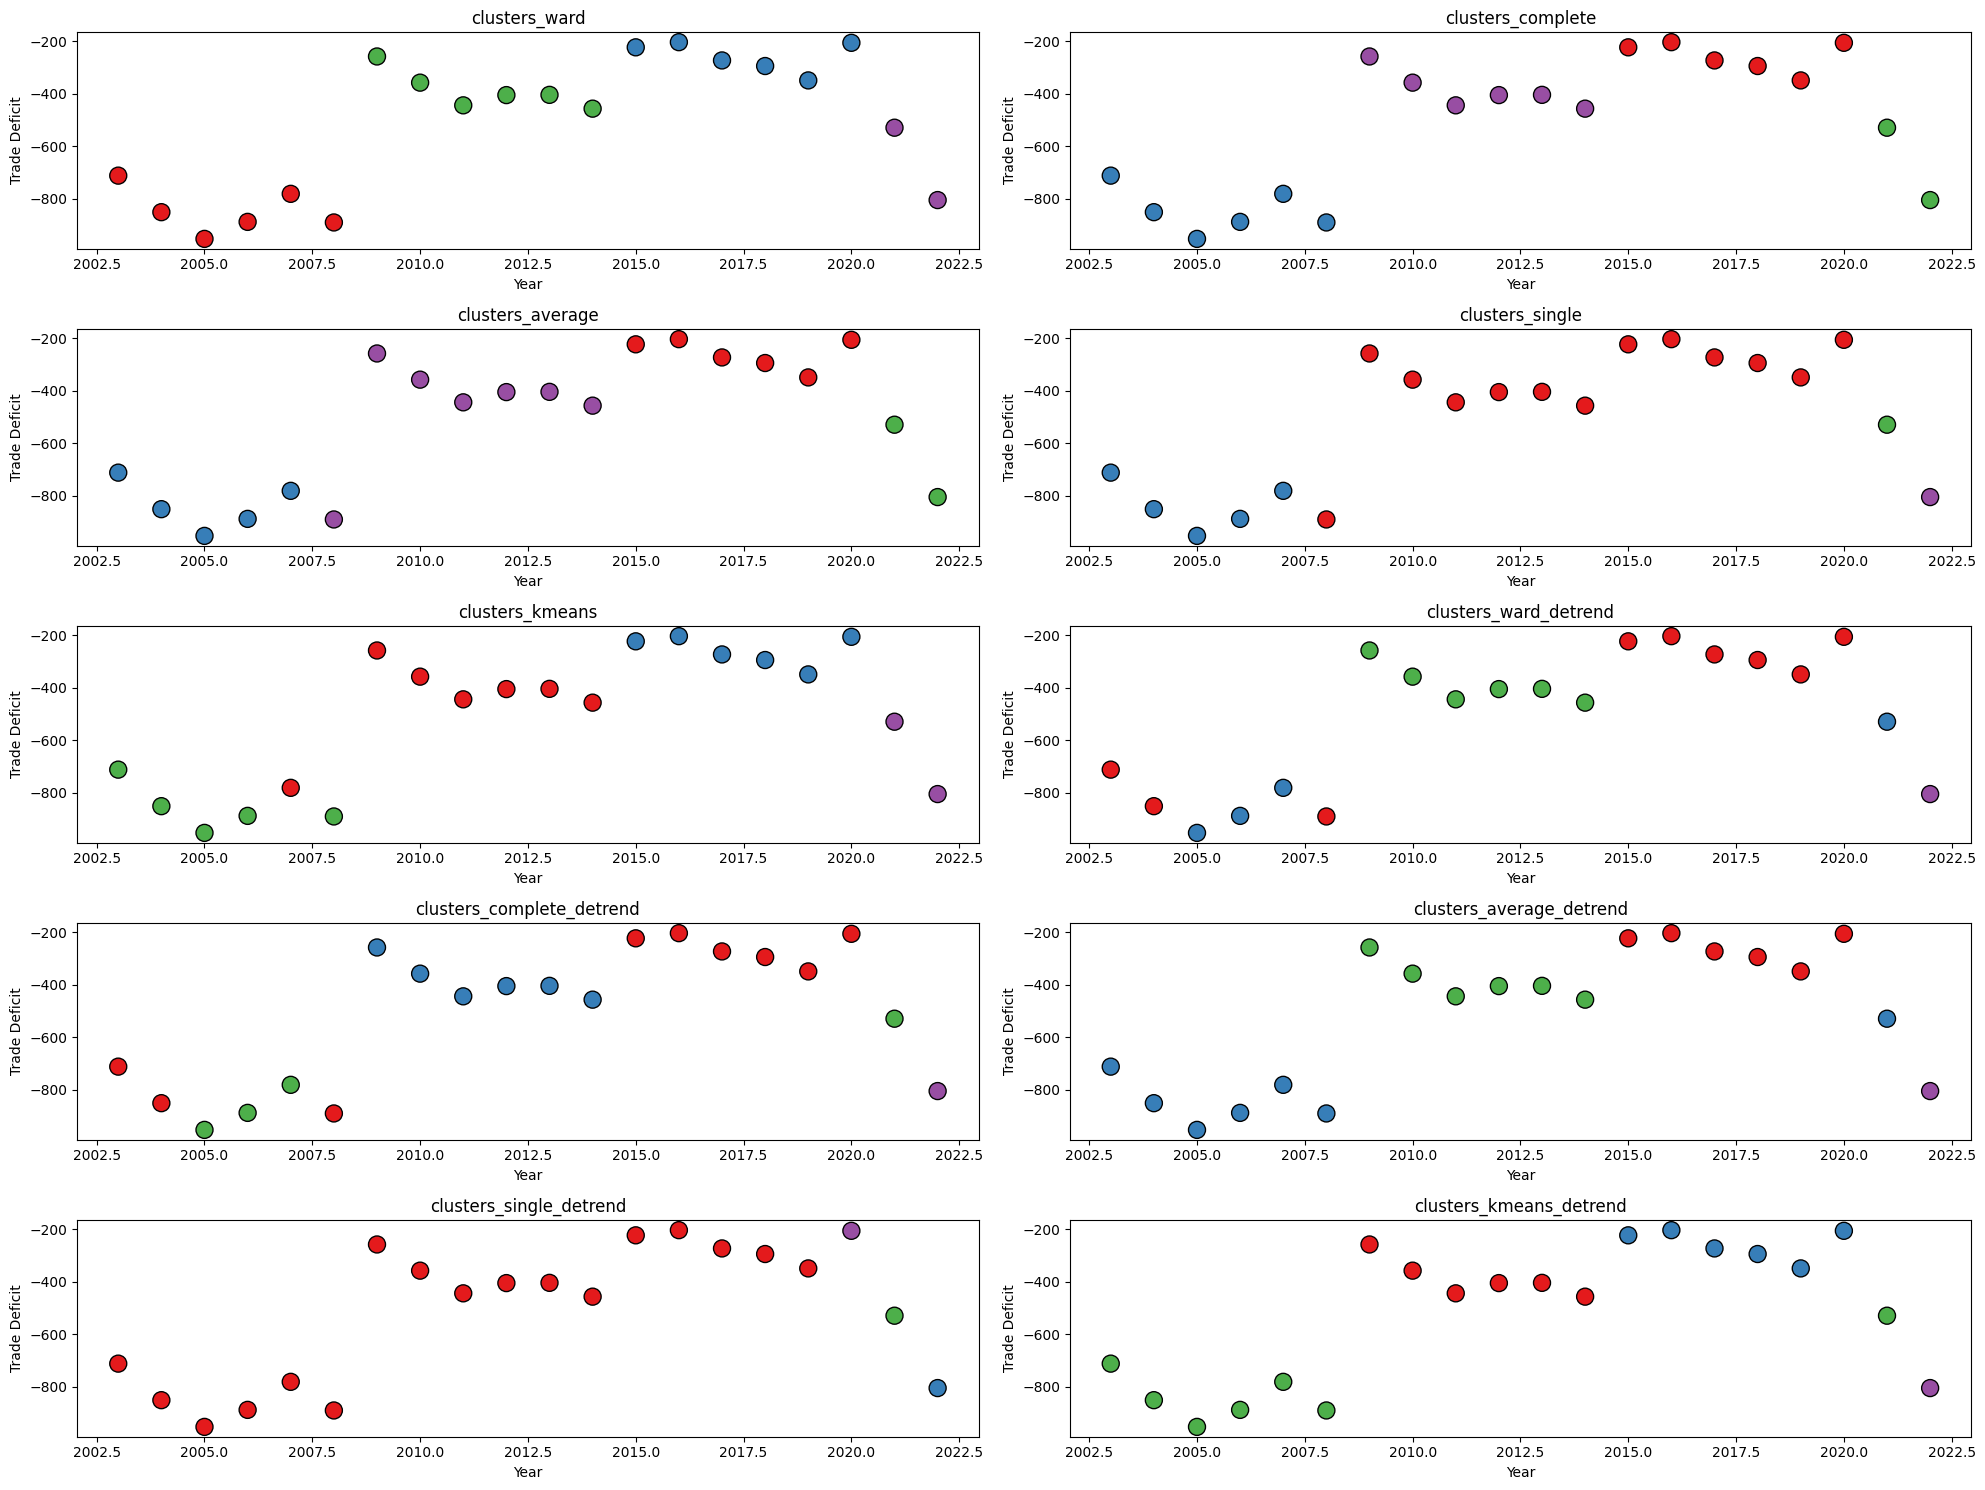

In [237]:
high_contrast_palette = sns.color_palette("Set1", n_colors=4)

# Set up the plot
plt.figure(figsize=(20, 15))

# Plot each clustering method in a separate subplot
for i, method in enumerate(clustering_methods, start=1):
    plt.subplot(5, 2, i)
    sns.scatterplot(
        x='year',
        y='trade_deficit',
        hue=method,
        data=data_and_clusters,
        s=150,
        marker='o',
        palette=high_contrast_palette,
        edgecolor='black',
        legend=None
    )
    plt.title(method)
    plt.xlabel('Year')
    plt.ylabel('Trade Deficit')

plt.tight_layout()
plt.show()

- Again, the graphs above are illustrating the fact that clusters formed by Ward and complete methods have captured the structural breaks
- Although capturing the structural changes are important on its own, it doesnt mean that the features are necessarily similar and close. hence, other methods might still provide additional valuable insights, eventhough in the graphs above, the clusters seem sparse and noisy.

To determine this, I'll visualize the data using T-SNE, to see the clusters in 2D, and better underestand the feature groupings.

In [238]:
# Run t-SNE
tsne = TSNE(n_components=2, random_state=45, perplexity=10, n_iter=3000)
tsne_results = tsne.fit_transform(data_scaled)

# Add t-SNE results to the dataframe
tsne_df = pd.DataFrame({
    'TSNE_1': tsne_results[:, 0],
    'TSNE_2': tsne_results[:, 1]
})
tsne_df = pd.concat([tsne_df, cluster_data], axis=1)

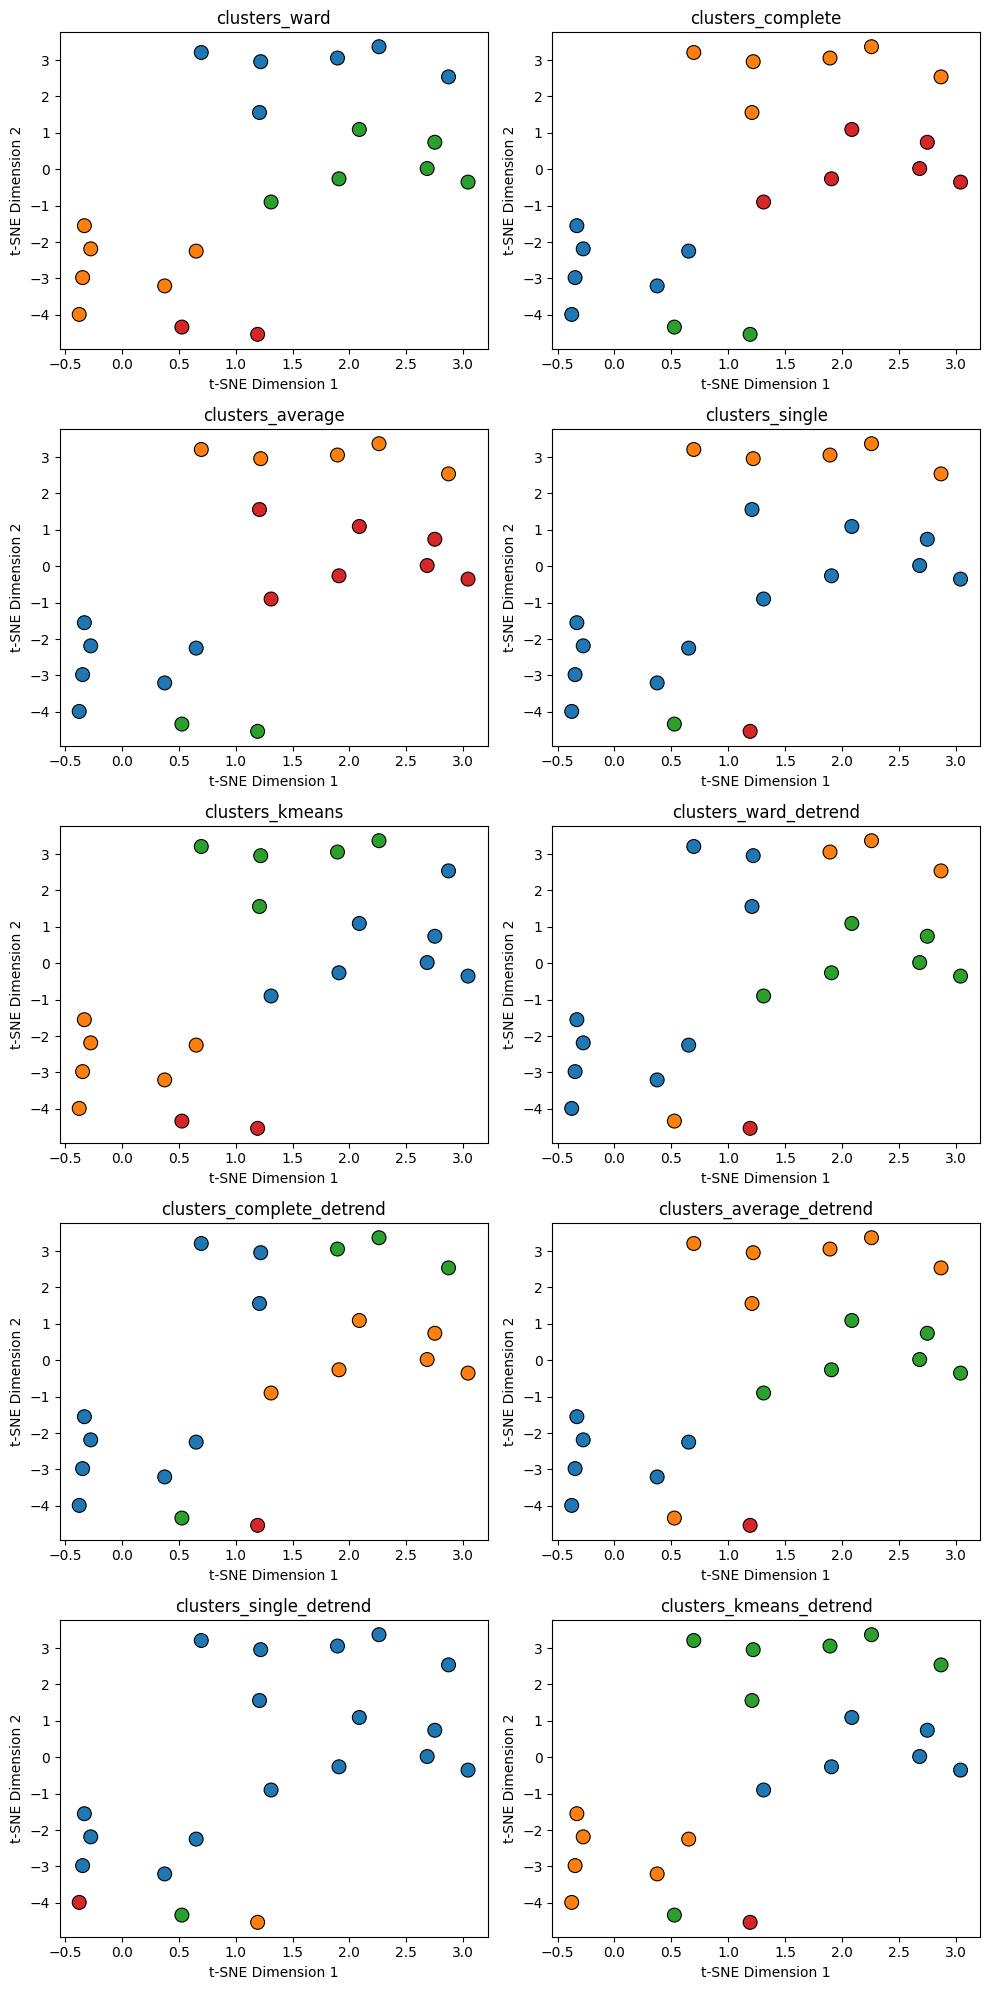

In [239]:
# Plotting
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed
for i, method in enumerate(clustering_methods, 1):
    ax = plt.subplot(5, 2, i)
    sns.scatterplot(
        x='TSNE_1',
        y='TSNE_2',
        hue=method,
        palette='tab10',
        data=tsne_df,
        s=100,
        edgecolor='black',
        legend=None
    )
    ax.set_title(method)
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')


plt.tight_layout()
plt.show()

The graphs above accurately illustrate my point. for instance, looking at k-means clusters, it seems as if the data points are better clustered considering the distance between the points, compared to ward for example.
If the dataset was bigger, I could have included 2 cluster labels for prediction instead of one. However, here, this would result in over-specification and overfitting. Thus, I'd rather keep the structural changes that the Ward method captured

For final examination, a simple linear regression was fitted for each of the clusters, with its corresponding R2 printed. Note that these will only capture breaks in the intercept coefficient and not the slope. as it was expected, since best clusters for prediction here correspond to structural breaks, ward and complete methods ran on raw scaled data are performing better for prediction purposes.

**Note** Since there are too many independent variables in comparison to the number of data points, exploring this requires dimensionality reduction, Thus the use of PCA.

In [240]:
pca = PCA()

pca.fit(data_scaled)

data_pca = pca.transform(data_scaled)

# Create a DataFrame from the transformed data
data_pca_df = pd.DataFrame(data_pca, columns=[f"PC{i+1}" for i in range(data_pca.shape[1])])
dim_reduced_data = data_pca_df.iloc[:, :5]
dim_reduced_data['year'] = data['year']
dim_reduced_data['trade_deficit'] = data['trade_deficit']

In [241]:
# Define your dependent variable (y)
y = dim_reduced_data['trade_deficit']  # replace 'your_dependent_variable' with your actual dependent variable

# List of cluster columns
cluster_columns = [
    'clusters_ward', 'clusters_complete', 'clusters_average', 'clusters_single', 'clusters_kmeans',
    'clusters_ward_detrend', 'clusters_complete_detrend', 'clusters_average_detrend', 'clusters_single_detrend', 'clusters_kmeans_detrend'
]

# Store the regression results for each cluster column
results = {}

for cluster_col in cluster_columns:
    # One-hot encode the current cluster column
    encoder = OneHotEncoder(drop='first')
    encoded_cluster = encoder.fit_transform(cluster_data[[cluster_col]]).toarray()
    encoded_cluster_df = pd.DataFrame(encoded_cluster, columns=encoder.get_feature_names_out([cluster_col]))

    # Prepare the independent variables (X)
    X = dim_reduced_data.drop(columns=['trade_deficit']).copy()
    X = pd.concat([X, encoded_cluster_df], axis=1)

    # Add a constant to the model (intercept)
    X = sm.add_constant(X)

    # Fit the regression model
    model = sm.OLS(y, X).fit()

    # Store the summary of the regression model
    results[cluster_col] = model.rsquared

# the baseline model
X = dim_reduced_data.drop(columns=['trade_deficit']).copy()
X = sm.add_constant(X)

# Fit the regression model
baseline_r2 = sm.OLS(y, X).fit().rsquared
print(f"Baseline R2 without the cluster feature: {baseline_r2}\n")

# Print the summary of each regression model
for cluster_col, summary in results.items():
    print(f"R2 difference from the baseline for {cluster_col}:{round(summary - baseline_r2, 2)}")

# in include both for ward for example
encoder = OneHotEncoder(drop='first')
encoded_cluster = encoder.fit_transform(cluster_data[['clusters_complete']]).toarray()
encoded_cluster_df = pd.DataFrame(encoded_cluster, columns=encoder.get_feature_names_out(["clusters_complete"]))
encoded_cluster_detrend = encoder.fit_transform(cluster_data[['clusters_complete_detrend']]).toarray()
encoded_cluster_detrend_df = pd.DataFrame(encoded_cluster, columns=encoder.get_feature_names_out(["clusters_complete_detrend"]))
X = pd.concat([X, encoded_cluster_df, encoded_cluster_detrend_df], axis=1)

Baseline R2 without the cluster feature: 0.8784568101521926

R2 difference from the baseline for clusters_ward:0.1
R2 difference from the baseline for clusters_complete:0.1
R2 difference from the baseline for clusters_average:0.06
R2 difference from the baseline for clusters_single:0.09
R2 difference from the baseline for clusters_kmeans:0.09
R2 difference from the baseline for clusters_ward_detrend:0.01
R2 difference from the baseline for clusters_complete_detrend:0.01
R2 difference from the baseline for clusters_average_detrend:0.05
R2 difference from the baseline for clusters_single_detrend:0.07
R2 difference from the baseline for clusters_kmeans_detrend:0.05


R2 change was negative and detrending didn't add much value in comparison.

### Cluster inference for new data points

Since `sklearn`'s `AgglomerativeClustering` does not provide a `predict` method, the cluster prediction for new points must be written using the centroids. The inference logic is tested below.

**Inference Logic**:
>1. Calculate the distance from each new point to the clustroid of the clusters
>2. assign the point to the nearest cluster.


In [242]:
result = []

ddf = pd.DataFrame(data_detrended_scaled, columns=detrended_data.columns)
labels = model_ward_detrend.labels_

# Calculate cluster centers
cluster_centers = np.zeros((model_ward_detrend.n_clusters, data_detrended_scaled.shape[1]))  # (4, 19)
for i in range(model_ward_detrend.n_clusters):
    cluster_centers[i] = data_detrended_scaled[labels == i].mean(axis=0).T

# Check that the data in ddf is correctly formatted
for index, row in ddf.iterrows():
    row = row.values
    distances = [np.linalg.norm(row - center) for center in cluster_centers]
    predicted_cluster = np.argmin(distances)
    result.append(predicted_cluster)

print(result)

[0, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 3]


### Saving Models for Detrending and Clustering

The following steps outline the process for saving the models used for detrending and clustering to disk:

1. **Detrending Model**: Save the model used for removing trends from the data.
2. **Clustering Model**: Save the model used for identifying clusters within the dataset.

In [ ]:
data['ward_cluster_trend_corrected'] = clusters_ward

data_save_path = r"../files/data/1_end.xlsx"
dictionary_save_path = r"../files/models/detrend_model_dict.pkl"
clustrer_centers_save_path = r"../files/models/clustrer_model.pkl"

data.to_excel(data_save_path, index=False)

with open(dictionary_save_path, 'wb') as f:
    pickle.dump(models, f)

with open(clustrer_centers_save_path, 'wb') as f:
    pickle.dump(cluster_centers.T, f)